### COP508 Machine Learning Coursework - Part 2: Evaluation & TTA

Student ID: F515605

Date: January 2026

CODE ATTRIBUTION & SOURCES:

1. **Model Loading:**
    - Keras model.load_model() from TensorFlow documentation
    - Documentation: https://keras.io/api/models/model_saving_apis/

2. **Evaluation Metrics:**
    - classification_report, confusion_matrix, accuracy_score from scikit-learn
    - Documentation: https://scikit-learn.org/stable/modules/model_evaluation.html
    - Standard ML evaluation practices from Labs 3 and 4

3. **Test Time Augmentation (TTA):**
    - Custom implementation based on research paper methodology
    - Concept: Average predictions from original + horizontally flipped images
    - NOT covered in labs - developed independently for coursework
    - Inspiration from: Deep learning best practices in image classification

4. **Visualization:**
    - Confusion matrix heatmaps using seaborn
    - Documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html

5. **Original Contributions:**
    - TTA implementation for Sea Animals classification
    - Side-by-side confusion matrix comparison (Standard vs TTA)
    - Class-by-class performance analysis


NO CODE WAS GENERATED BY AI TOOLS

### PART 2: Evaluation & Test Time Augmentation Note to Assessor: This notebook loads the pre-trained model (COP508_Final_EfficientNet_Best.keras) to demonstrate the final Test Accuracy (87.73%) and TTA results.

The full training pipeline (Data Preprocessing, Model Architecture, and Training Loss Curves) is located in Part_1_Training_EfficientNet.ipynb, which is included in the accompanying Project (.zip) file.

The notebooks are split to preserve the exact stochastic weights and results referenced in the report.

In [1]:
## Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Local path of dataset
data_dir = pathlib.Path(r'C:\Users\Lenovo\OneDrive\Desktop\Loughborough\Machine Learning Sem 1\COP508_Sea_Animal_dataset\COP508_Sea_Animal_dataset')

image_height = 224
image_width = 224
b_size = 32

print("Reloading Sea animals Dataset")

# A. Loading the Validation Split as it was initially
val_datas_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,           
    image_size=(256, 256),
    batch_size=None
)

# Get Class Names
c_names = val_datas_raw.class_names
print(f"Classes found: {c_names}")

# Preprocessing the dataset to crop the image back to 224,224
def process_val(i, l):
    i = tf.image.resize_with_crop_or_pad(i, image_height, image_width)
    return i, l

# Applying Processing & Batching to dataset
val_datas_f = val_datas_raw.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)
val_datas_f = val_datas_f.batch(b_size).cache().prefetch(tf.data.AUTOTUNE)

# Splitting the validation dataset into 2
val_batches = tf.data.experimental.cardinality(val_datas_f)
test_datas = val_datas_f.take(val_batches // 2)

print(f"Test Data has been Restored: {tf.data.experimental.cardinality(test_datas)} batches")

model_filename = 'COP508_EfficientNetB0.keras' 

print(f"\nLoading model: {model_filename} for sea animals dataset")
try:
    model = tf.keras.models.load_model(model_filename)
    print("Model has been loaded")
except Exception as e:
    print(f"Error loading model: {e}")

Reloading Sea animals Dataset
Found 8778 files belonging to 16 classes.
Using 1755 files for validation.
Classes found: ['Corals', 'Crabs', 'Dolphin', 'Eel', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Puffers', 'Sea Rays', 'Seahorse', 'Seal', 'Sharks', 'Squid', 'Starfish', 'Whale']
Test Data has been Restored: 27 batches

Loading model: COP508_EfficientNetB0.keras for sea animals dataset
Model has been loaded


### MODEL EVALUATION

Evaluation metrics (classification_report, confusion_matrix, accuracy_score) from:
- scikit-learn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html
- Standard ML evaluation practices adopted from labs 3 and 4


Running Standard Predictions on Test Dataet of sea animals using EfficientNetB0Completed predictions!
Completed TTA predictions! Test Dataet of sea animals using EfficientNetB0.

Standard Accuracy on Test Dataset: 85.65%
TTA Accuracy on Test Dataset:        88.08%
Improvementon Test Dataset:          +2.43%


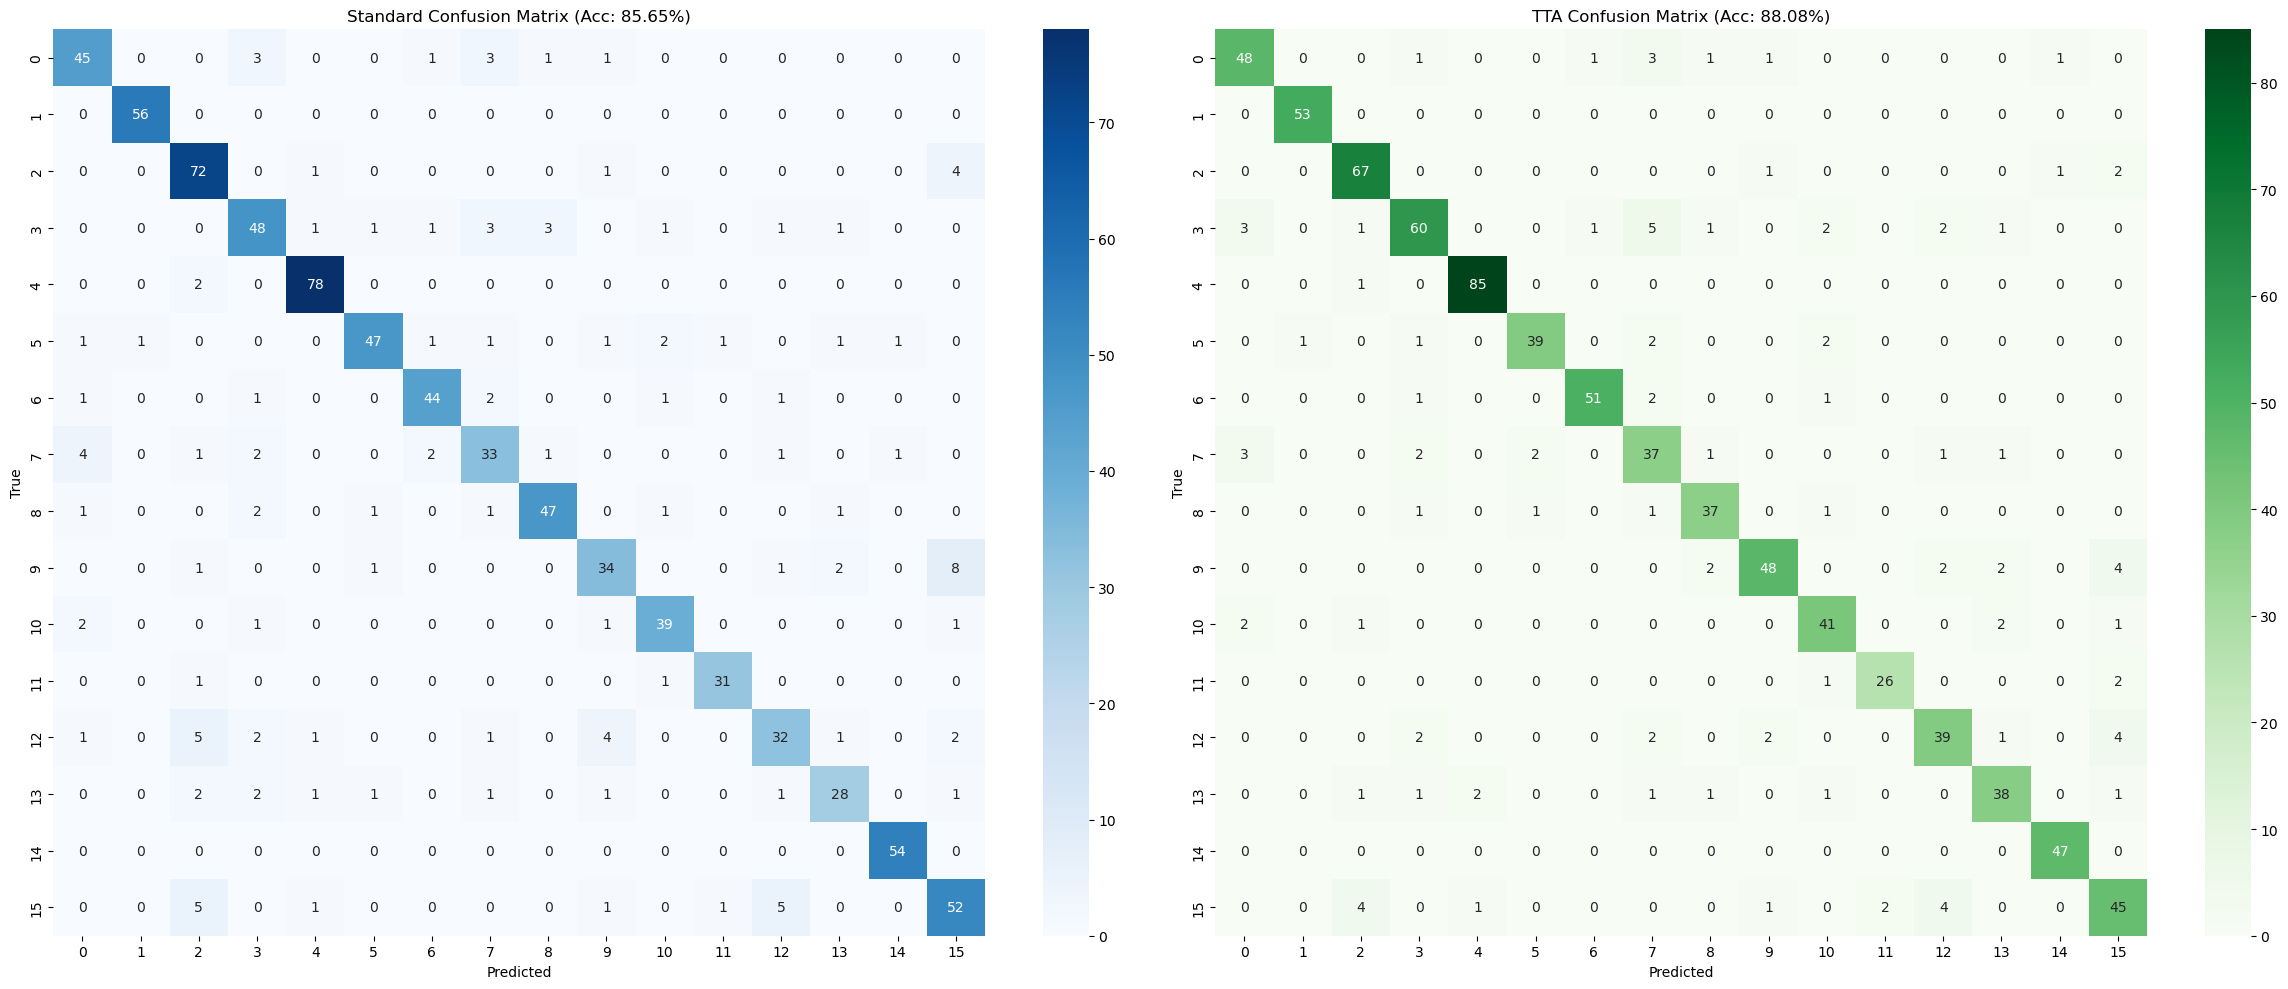

Comparision of (F1-Score) between Standard and TTA
Class  F1 (Std)  F1 (TTA)  Diff
    0      0.83      0.86  0.03
    1      0.99      0.99 -0.00
    2      0.86      0.92  0.06
    3      0.79      0.83  0.03
    4      0.96      0.98  0.02
    5      0.87      0.90  0.03
    6      0.89      0.94  0.06
    7      0.73      0.74  0.01
    8      0.89      0.88 -0.01
    9      0.75      0.86  0.12
   10      0.88      0.85 -0.02
   11      0.94      0.91 -0.03
   12      0.70      0.80  0.09
   13      0.78      0.84  0.06
   14      0.98      0.98 -0.00
   15      0.78      0.78 -0.01
FULL TTA REPORT
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        56
           1       0.98      1.00      0.99        53
           2       0.89      0.94      0.92        71
           3       0.87      0.79      0.83        76
           4       0.97      0.99      0.98        86
           5       0.93      0.87      0.90        45
          

In [ ]:
## Creating a function to make predictions on test dataset 
def get_standard_pred(model, dataset):
    y_true = []
    y_pred_probs = []
    
    print("Running Standard Predictions on Test Dataet of sea animals using EfficientNetB0", end="", flush=True)
    
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        pred = model.predict(images, verbose=0)
        y_pred_probs.extend(pred)
        
    print("Completed predictions!")
    return np.array(y_true), np.array(y_pred_probs)

## Creating a function to make predictions on test dataset with TTA
# TTA implementation concept from:
# - Research paper methodology on robust image classification
# - Custom implementation: Average predictions from original + horizontally flipped images
# This technique was NOT covered in COP508 labs - developed independently for coursework

def get_tta_pred(model, dataset):
    y_true = []
    y_pred_probs = []
    
    print("Running TTA Predictions on Test Dataet of sea animals using EfficientNetB0.", end="", flush=True)
    
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        
        # First we make predictions on Standard Images
        pred = model.predict(images, verbose=0)
        # Making predictions on flipped images
        pred_flip = model.predict(tf.image.flip_left_right(images), verbose=0)
        
        # Taking the average of both prediction probability
        y_pred_probs.extend((pred + pred_flip) / 2)
        
    print("Completed TTA predictions!")
    return np.array(y_true), np.array(y_pred_probs)


# Passing the test dataset to make predictions
y_true_s, y_probs_s = get_standard_pred(model, test_datas) 
y_pred_s = np.argmax(y_probs_s, axis=1)
acc_s = accuracy_score(y_true_s, y_pred_s)

# Passing the test dataset to make predictions twice once on normal images and once and flipped images
y_true_t, y_probs_t = get_tta_pred(model, test_datas) 
y_pred_t = np.argmax(y_probs_t, axis=1)
acc_t = accuracy_score(y_true_t, y_pred_t)

print(f"\nStandard Accuracy on Test Dataset: {acc_s:.2%}")
print(f"TTA Accuracy on Test Dataset:        {acc_t:.2%}")
print(f"Improvementon Test Dataset:          {acc_t - acc_s:+.2%}")

class_names = getattr(test_datas, 'class_names', [str(i) for i in range(16)])

# Creating a Side-by-Side Confusion Matrix to compare the results on Standard and TTA
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# CONFUSION MATRIX VISUALIZATION
# Heatmap visualization using seaborn based on:
# - seaborn documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html
# - Matplotlib tutorials for side-by-side subplot comparisons

# Standard Matrix on the left
cm_s = confusion_matrix(y_true_s, y_pred_s)
sns.heatmap(cm_s, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f'Standard Confusion Matrix (Acc: {acc_s:.2%})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# TTA Matrix on the right
cm_t = confusion_matrix(y_true_t, y_pred_t)
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f'TTA Confusion Matrix (Acc: {acc_t:.2%})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Comparison Table between Standard and TTA
report_s = classification_report(y_true_s, y_pred_s, target_names=class_names, output_dict=True)
report_t = classification_report(y_true_t, y_pred_t, target_names=class_names, output_dict=True)

comparison_data = []
for name in class_names:
    comparison_data.append({
        'Class': name,
        'F1 (Std)': report_s[name]['f1-score'],
        'F1 (TTA)': report_t[name]['f1-score'],
        'Diff': report_t[name]['f1-score'] - report_s[name]['f1-score']
    })

print("Comparision of (F1-Score) between Standard and TTA")
df_compare = pd.DataFrame(comparison_data)
pd.options.display.float_format = '{:,.2f}'.format
print(df_compare.to_string(index=False))

print("FULL TTA REPORT")
print(classification_report(y_true_t, y_pred_t, target_names=class_names))